Group and sum by metaprogram problem solved with: https://stackoverflow.com/questions/39650749/group-by-sparse-matrix-in-scipy-and-return-a-matrix

#### Load modules

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

import scanpy as sc
import squidpy as sq

import scipy

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# sample BT1717 was excluded because it was creating problems during metaprogram annotation, and it has extremely high number of cells that confounds the results
samples = ['BT2126', '7EP41', '3EP8', '7EP1', 'BT775', 'BT2169', 'BT1804', '11EP22',  'BT1743']

path = ['/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231020__200939__BT2126_BT1745/output-XETG00083__0010652__Region_4__20231020__201259',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231102__215055__7EP1_7EP41_3EP8/output-XETG00083__0010575__Region_3__20231102__215155',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231102__215055__7EP1_7EP41_3EP8/output-XETG00083__0010619__Region_3__20231102__215155',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231102__215055__7EP1_7EP41_3EP8/output-XETG00083__0010619__Region_5__20231102__215155',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231107__203958__BT1717_BT775/0010501-Region_2',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231109__203408__BT1804_BT2169/output-XETG00083__0010498__Region_1__20231109__203421',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231109__203408__BT1804_BT2169/output-XETG00083__0010775__Region_1__20231109__203421',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/output-XETG00083__0010540__Region_1__20231208__193752',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/output-XETG00083__0010553__Region_3__20231208__193752']

metadata = ['/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231020__200939__BT2126_BT1745/data/individual/cell_ID_0010652-Region_4.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231102__215055__7EP1_7EP41_3EP8/data/individual/cell_ID_0010575-Region_3.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231102__215055__7EP1_7EP41_3EP8/data/individual/cell_ID_0010619-Region_3.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231102__215055__7EP1_7EP41_3EP8/data/individual/cell_ID_0010619-Region_5.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231107__203958__BT1717_BT775/data/individual/cell_ID_0010501-Region_2.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231109__203408__BT1804_BT2169/data/individual/cell_ID_0010498-Region_1.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231109__203408__BT1804_BT2169/data/individual/cell_ID_0010775-Region_1.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/data/individual/cell_ID_0010540-Region_1.csv',            
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/data/individual/cell_ID_0010553-Region_3.csv']


anndata_list = []
for i in range(len(samples)):
    adata = sc.read_10x_h5(filename = path[i]+'/cell_feature_matrix.h5')
    df = pd.read_csv(path[i]+'/cells.csv.gz')
    
    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()
    
    #adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
    adata.obsm["spatial"] = np.array([adata.obs.x_centroid*0.325, adata.obs.y_centroid*0.325]).transpose().astype('float64')
    
    anno = pd.read_csv(metadata[i], index_col = 0)
    if 'X' in anno.columns:
        anno.index = anno['X']
    
    adata = adata[anno.index,:]
    
    adata.obs['Metaprogram'] = anno['group']
    adata.obs['Metaprogram'] = adata.obs['Metaprogram'].astype('category')
    adata.obs['sample'] = samples[i]
    
    anndata_list.append(adata)
    
    print(samples[i])

adata = sc.concat(anndata_list)

BT2126
7EP41
3EP8
7EP1
BT775
BT2169
BT1804
11EP22
BT1743


In [3]:
# Subset to remove "Unassigned" program and oligodendrocytes (too little cell number)
adata = adata[~adata.obs['Metaprogram'].isin(['Unassigned', 'Oligodendrocytes'])]

# Create a color palette for each unique Metaprogram
metaprogram_names = ["Cycling", "Neuroepithelial-like", "Radial glia-like", 
                          "NPC-like" ,"Ependymal-like", "Mesenchymal", "Unassigned", 
                          "T-cell", "Myeloid", "Microglia", "Endothelial", "Neurons", "VLMCs", "Oligodendrocytes"]

metaprogram_colors = ["gray30","#F99E93FF","#9E5E9BFF","#74ADD1FF","#ACD39EFF","#96410EFF", 'black',
                   '#BDA14DFF', '#3EBCB6FF', '#0169C4FF', '#153460FF', '#D5114EFF' ,'#A56EB6FF' ,'#4B1C57FF']

metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))

ad = adata

In [4]:
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int, coord_type = 'generic', radius = 70.0)
    
    if len(adata_copy_int.obs.groupby('Metaprogram').size()) == 2:
        datf = pd.DataFrame(data = scipy.sparse.csr_matrix.todense((adata_copy_int.obsp['spatial_distances']>0)*1))
        datf['key'] = list(adata_copy_int.obs['Metaprogram'])
        neighmatrix = datf.groupby('key').sum().transpose()
    else:
        lb = LabelBinarizer(sparse_output=True)
        grouped = lb.fit_transform(adata_copy_int.obs['Metaprogram'].to_numpy()).T.dot((adata_copy_int.obsp['spatial_distances']>0)*1)
        neighmatrix = pd.DataFrame(data = scipy.sparse.csr_matrix.todense(grouped)).transpose()
        neighmatrix.set_axis(sorted(adata_copy_int.obs['Metaprogram'].unique()), axis = "columns", copy = False)
    
    adataneigh = sc.AnnData(neighmatrix)
    adataneigh.obs = adata_copy_int.obs
    adataneigh.obs['counts'] = list(np.sum(neighmatrix,axis=1))
    anndata_list.append(adataneigh)
    print(sample)

BT2126
7EP41
3EP8
7EP1
BT775
BT2169
BT1804
11EP22
BT1743


#### Compute centrality scores per sample

In [5]:
centralityScore_list = []
for i in range(len(anndata_list)):
    anndata_list[i].obsm["spatial"] = np.array([anndata_list[i].obs.x_centroid*0.325, anndata_list[i].obs.y_centroid*0.325]).transpose().astype('float64')
    anndata_list[i].X = np.nan_to_num(anndata_list[i].X)
    anndata_list[i] = anndata_list[i][anndata_list[i].obs['counts'] > 6]
    anndata_list[i].raw = anndata_list[i]
    
    sq.gr.spatial_neighbors(anndata_list[i], coord_type = "generic", delaunay = True)
    sq.gr.centrality_scores(anndata_list[i], cluster_key = "Metaprogram")

    dt = anndata_list[i].uns['Metaprogram_centrality_scores']
    dt['Metaprogram'] = dt.index
    dt['Sample'] = samples[i]
    
    centralityScore_list.append(dt)
    print(samples[i])

BT2126
7EP41
3EP8
7EP1
BT775
BT2169
BT1804
11EP22
BT1743


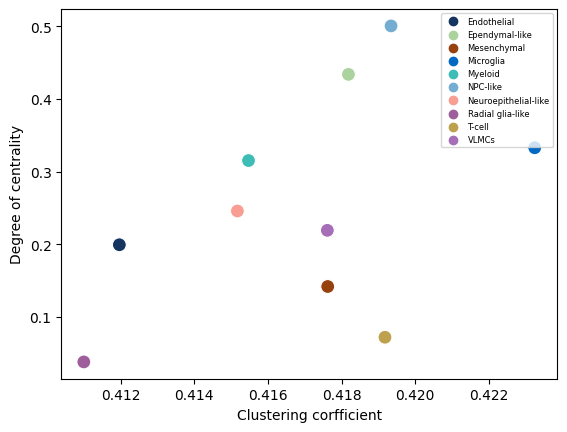

In [6]:
## Averaging metrics
dt = pd.concat(centralityScore_list)
dt = dt.groupby(['Metaprogram'], as_index=False).agg({'degree_centrality': 'mean', 'average_clustering': 'mean', 'closeness_centrality': 'mean'})

## Scatter plot
pt = sns.scatterplot(data=dt, x="average_clustering", y="degree_centrality", hue="Metaprogram", 
                     palette=metaprogram_to_color, legend = True, s = 100)
pt.set(xlabel = 'Clustering corfficient', ylabel = 'Degree of centrality')
pt.legend(fontsize = 6)
plt.show()

In [31]:
nhood_list = []
for i in range(len(anndata_list)):
    sq.gr.nhood_enrichment(anndata_list[i], cluster_key = "Metaprogram", seed = 1234)
    
    df = pd.DataFrame(anndata_list[i].uns['Metaprogram_nhood_enrichment']['zscore'])
    df.index = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df.columns = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df['Programs'] = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df = pd.melt(df, id_vars='Programs')
    
    nhood_list.append(df)
    #df_counts = pd.DataFrame(anndata_list[i].uns['Metaprogram_nhood_enrichment']['count'])

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

In [40]:
## Averaging metrics
dt = pd.concat(nhood_list)
dt = dt.groupby(['Programs', 'variable'], as_index=False).agg({'value': 'mean'})
dt = dt.pivot(index='Programs', columns='variable')['value']
dt.to_csv('/n/scratch/users/c/cao385/test.csv')